# Plot the Distribution of Segment Lengths for Euchromatic Domains

#### Setup

To generate the pattern of methylation marks, follow the `bedgraph_to_sequence.ipynb` example in `chromo_analysis`, found in [this](https://github.com/JosephWakim/chromo-analysis) repository.

#### Import Modules

In [1]:
import os
import sys
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Specify Paths to Mark Patterns

In [2]:
# Specify directory containing mark_patterns
mark_dir = "/home/groups/ajspakow/jwakim/downloads/mark_patterns"

# Load the bed files in the directory
mark_files = os.listdir(mark_dir)
mark_files = [file for file in mark_files if file.startswith("ENCFF683HCZ_Chr_")]
chr_inds = [int(file.split("_")[-1].split(".")[0]) for file in mark_files]
mark_files = [mark_file for _, mark_file in sorted(zip(chr_inds, mark_files))]
chr_inds = np.sort(chr_inds)

# Report the bed files in the directory
print("Mark Files:\n")
pprint(mark_files)

Mark Files:

['ENCFF683HCZ_Chr_1.txt',
 'ENCFF683HCZ_Chr_2.txt',
 'ENCFF683HCZ_Chr_3.txt',
 'ENCFF683HCZ_Chr_4.txt',
 'ENCFF683HCZ_Chr_5.txt',
 'ENCFF683HCZ_Chr_6.txt',
 'ENCFF683HCZ_Chr_7.txt',
 'ENCFF683HCZ_Chr_8.txt',
 'ENCFF683HCZ_Chr_9.txt',
 'ENCFF683HCZ_Chr_10.txt',
 'ENCFF683HCZ_Chr_11.txt',
 'ENCFF683HCZ_Chr_12.txt',
 'ENCFF683HCZ_Chr_13.txt',
 'ENCFF683HCZ_Chr_14.txt',
 'ENCFF683HCZ_Chr_15.txt',
 'ENCFF683HCZ_Chr_16.txt',
 'ENCFF683HCZ_Chr_17.txt',
 'ENCFF683HCZ_Chr_18.txt',
 'ENCFF683HCZ_Chr_19.txt',
 'ENCFF683HCZ_Chr_20.txt',
 'ENCFF683HCZ_Chr_21.txt',
 'ENCFF683HCZ_Chr_22.txt']


#### Load Methylation Patterns

In [3]:
mark_patterns = {}

for file in mark_files:
    
    # Identify the chromosome number
    chr_ind = int(file.split("_")[-1].split(".")[0])
    
    # Identify the path to the file
    file_path = os.path.join(mark_dir, file)
    
    # Load the mark path
    mark_pattern = np.loadtxt(file_path).astype(int)
    mark_patterns[chr_ind] = mark_pattern

#### Perform 101 Nucleosome Sliding Average

A 101-nucleosome sliding average is recommended by [MacPherson et al., PNAS, 2018](https://www.pnas.org/doi/10.1073/pnas.1812268115) before classifying nucleosomes into euchromatic and non-euchromatic domains.

In [4]:
def centered_window_average(arr, window_size=101):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")
    half_window = window_size // 2
    window = np.ones(window_size) / window_size
    window_average = np.convolve(arr, window, mode='valid')
    return window_average

smoothed_mark_patterns = {
    chr_ind: centered_window_average(mark_pattern)
    for chr_ind, mark_pattern in mark_patterns.items()
}

#### Identify Euchromatin by Average Methylation

We will use window-averaged methylation cutoffs established in [MacPherson et al., PNAS, 2018](https://www.pnas.org/doi/10.1073/pnas.1812268115) to classify euchromatic domains.

In [5]:
euch_cutoff = 0.53

In [6]:
is_euchromatin = {
    chr_ind: (mark_pattern < euch_cutoff)
    for chr_ind, mark_pattern in smoothed_mark_patterns.items()
}

#### Identify the Lengths of Euchromatin Segments

In [7]:
def get_euchromatin_lengths(is_euchromatin_arr):
    current_length = 0
    segment_lengths = []
    for value in is_euchromatin_arr:
        if value:
            current_length += 1
        else:
            if current_length > 0:
                segment_lengths.append(current_length)
                current_length = 0
    if current_length > 0:
        segment_lengths.append(current_length)
    return segment_lengths

In [8]:
euchromatin_lengths = {
    chr_ind: get_euchromatin_lengths(is_euchromatin_arr)
    for chr_ind, is_euchromatin_arr in is_euchromatin.items()
}

#### Plot the Distribution of Euchromatin Lengths

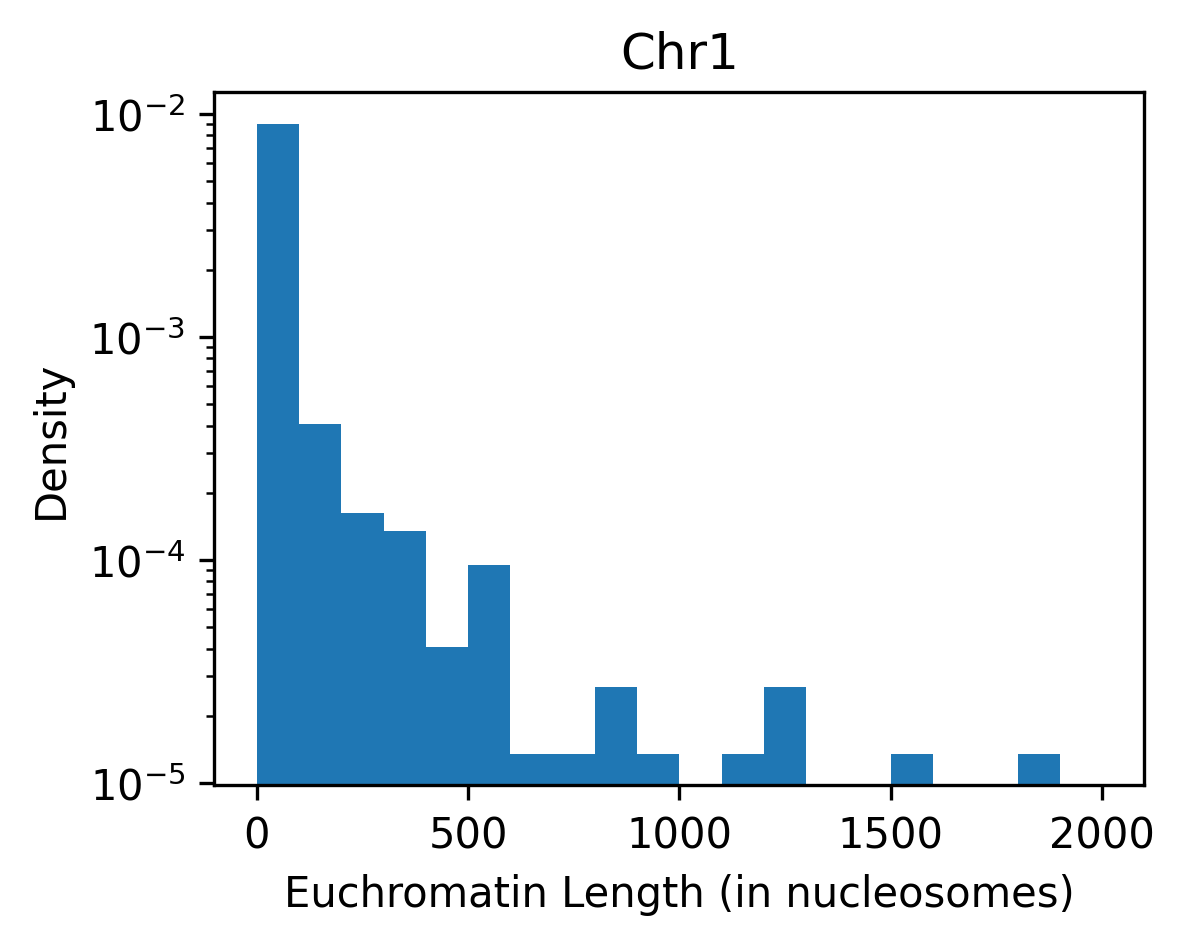

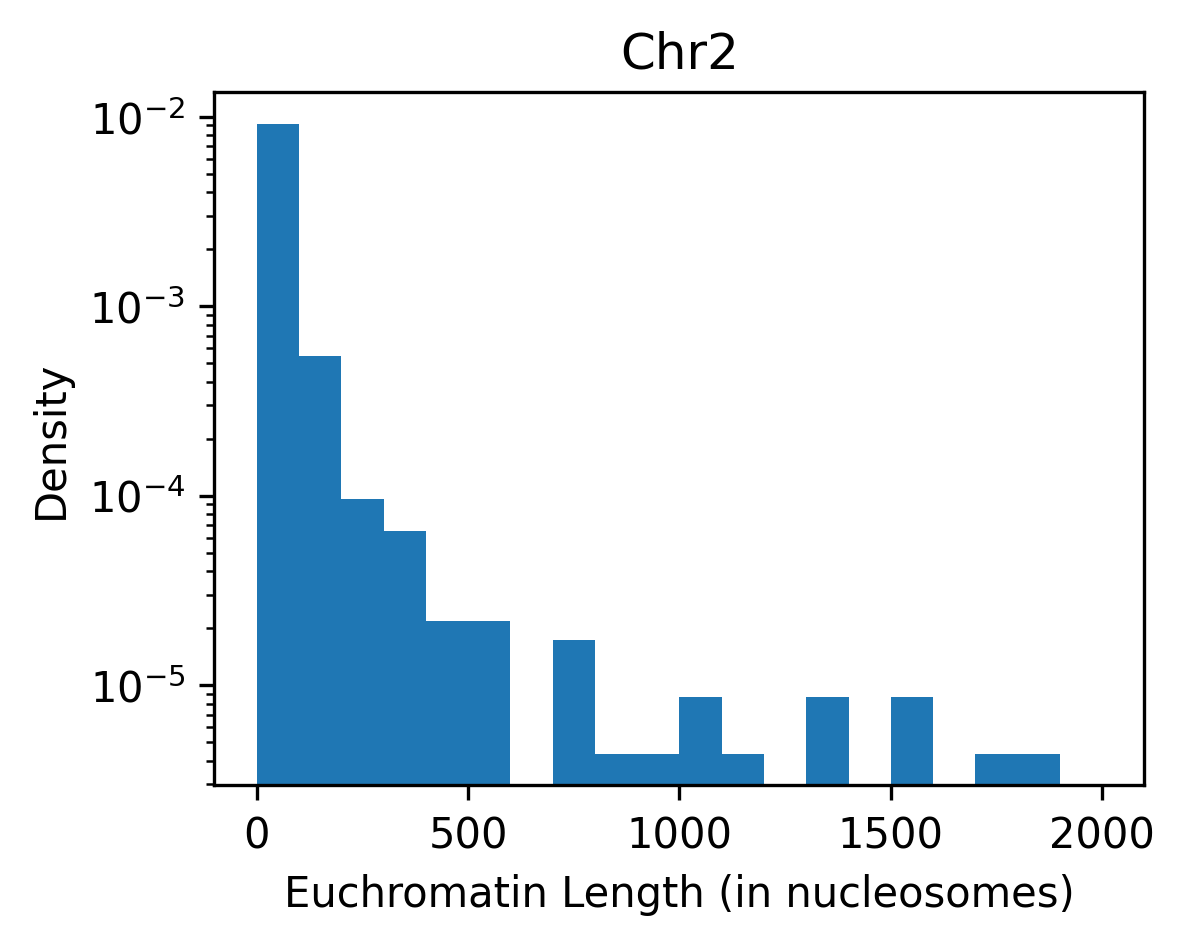

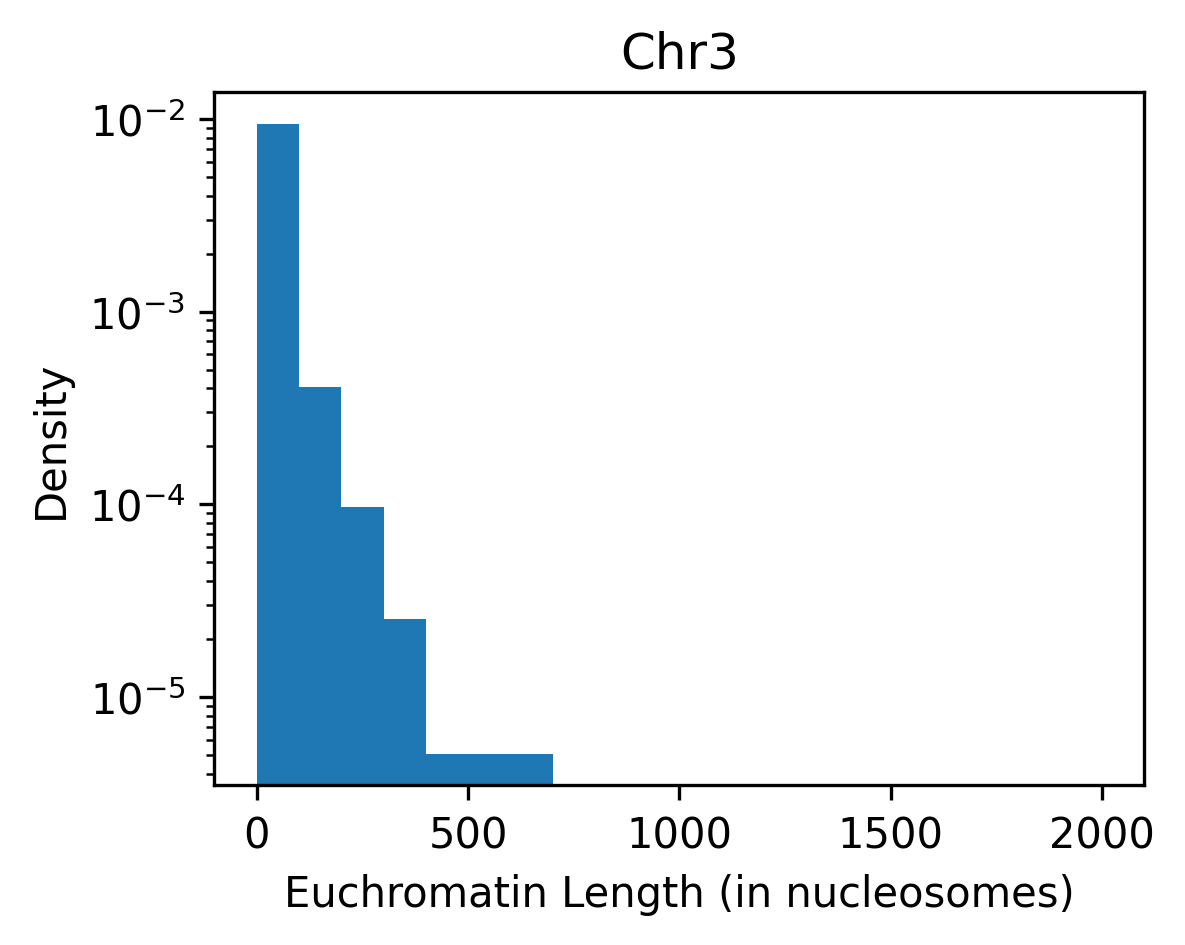

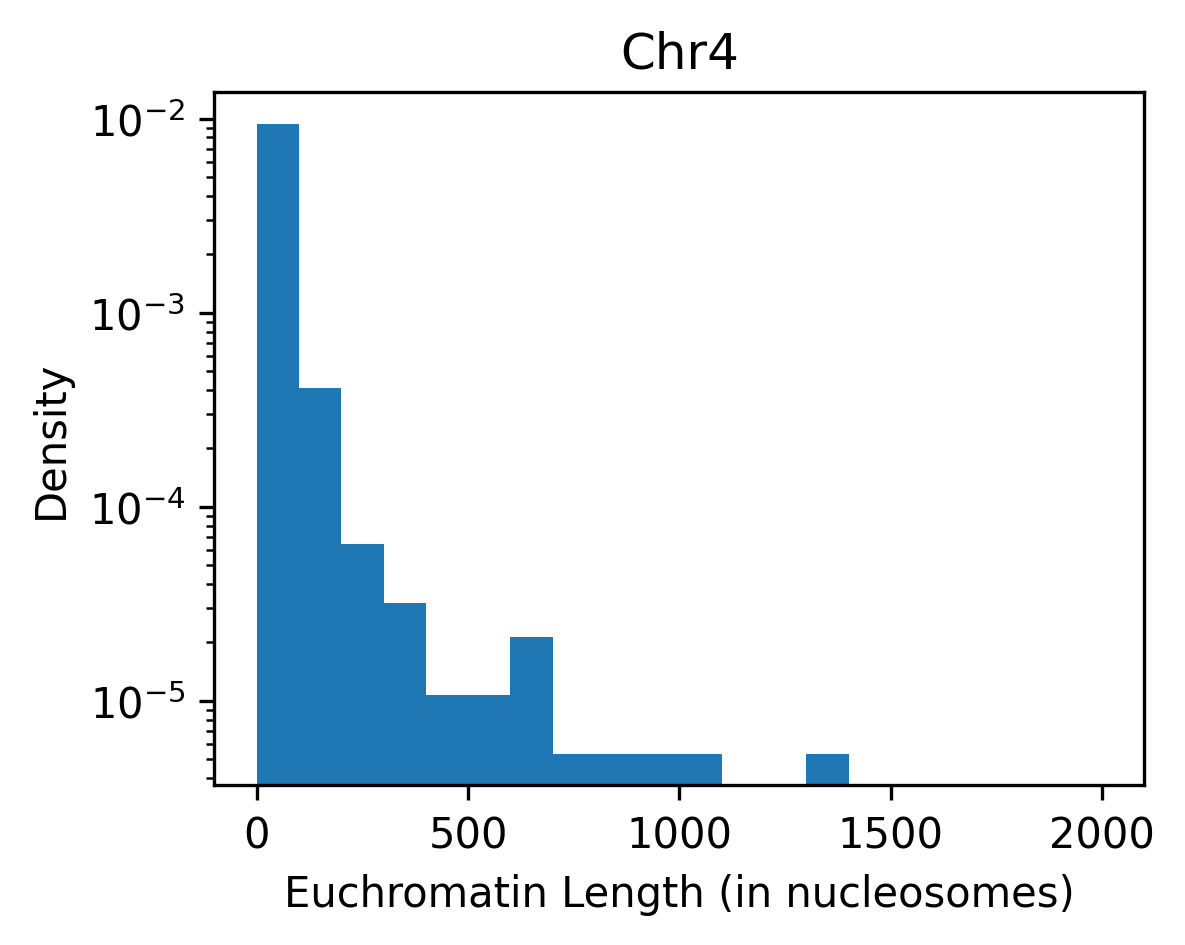

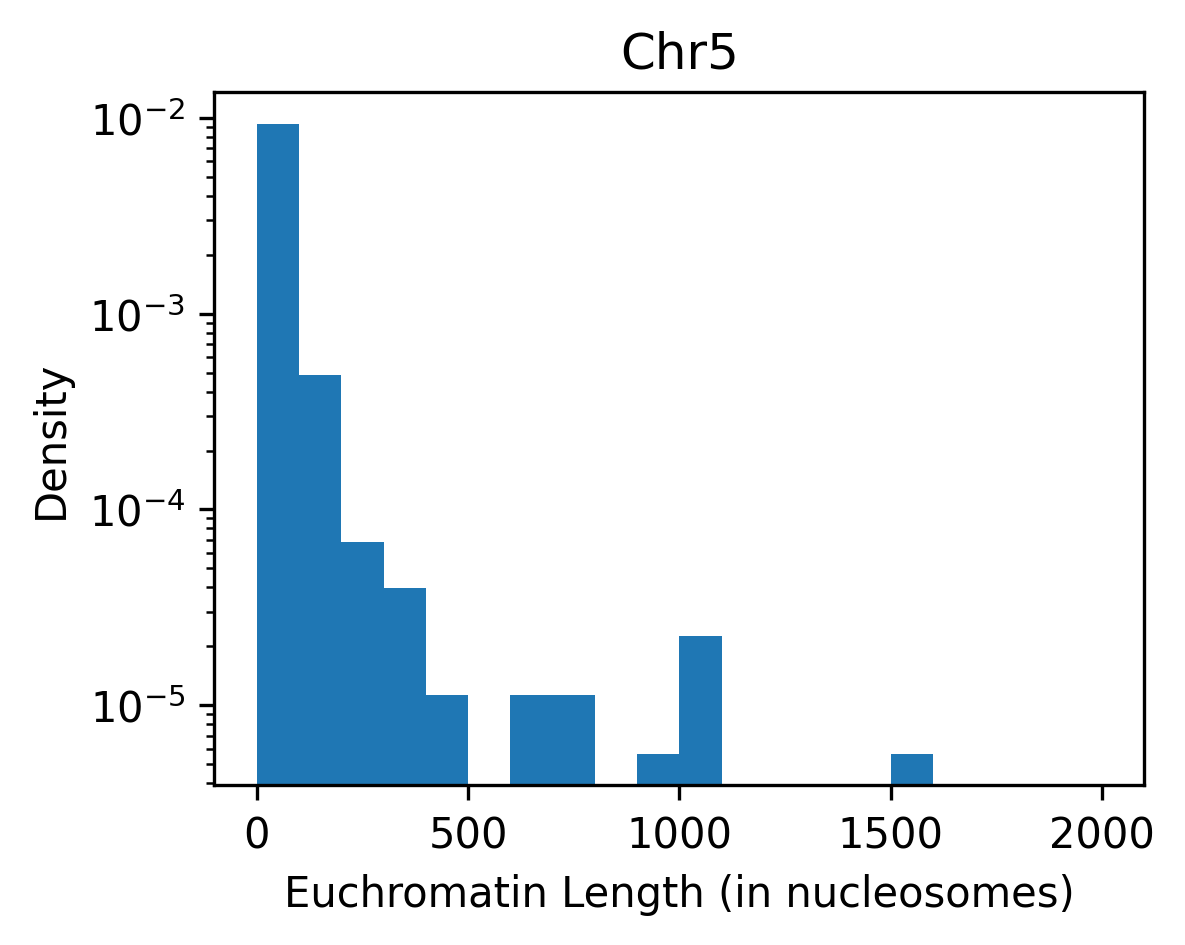

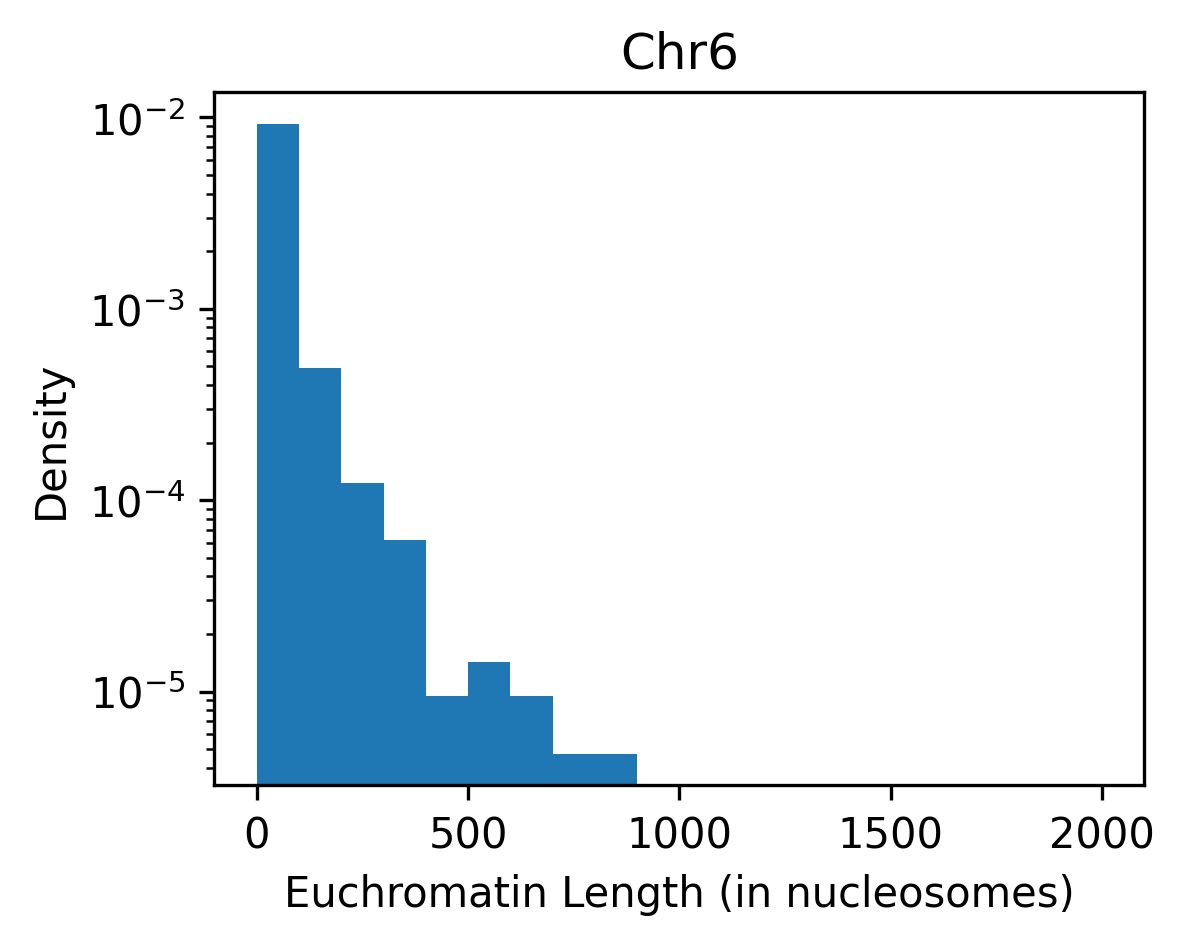

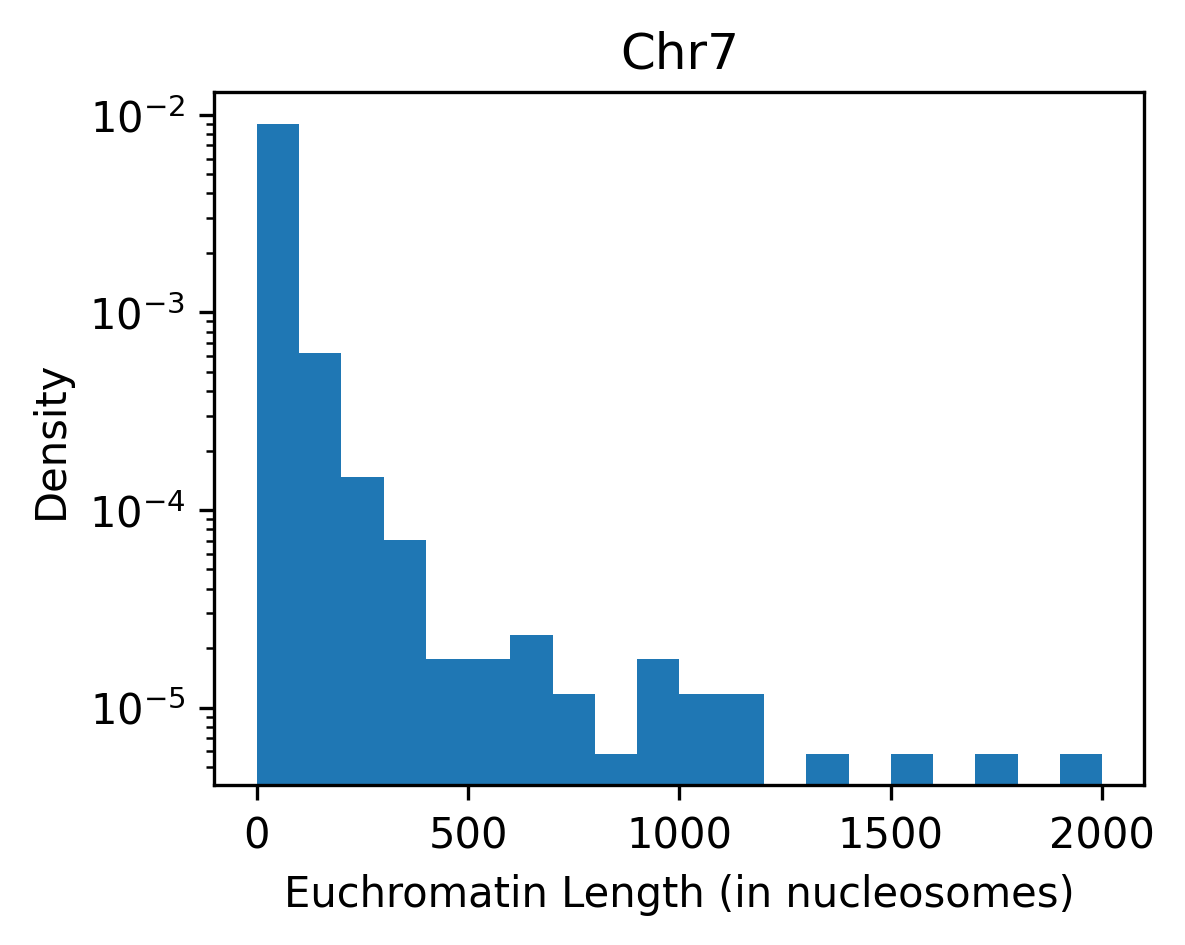

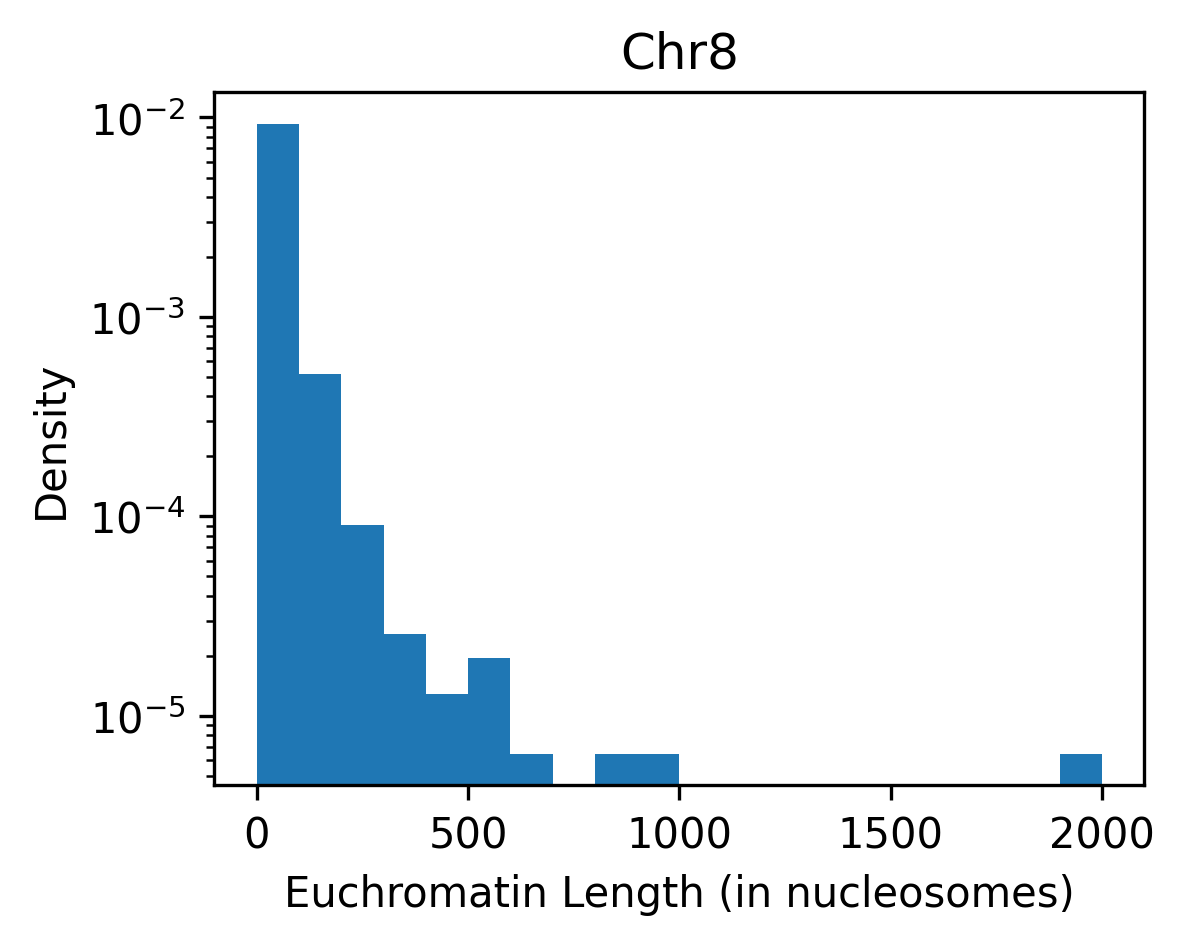

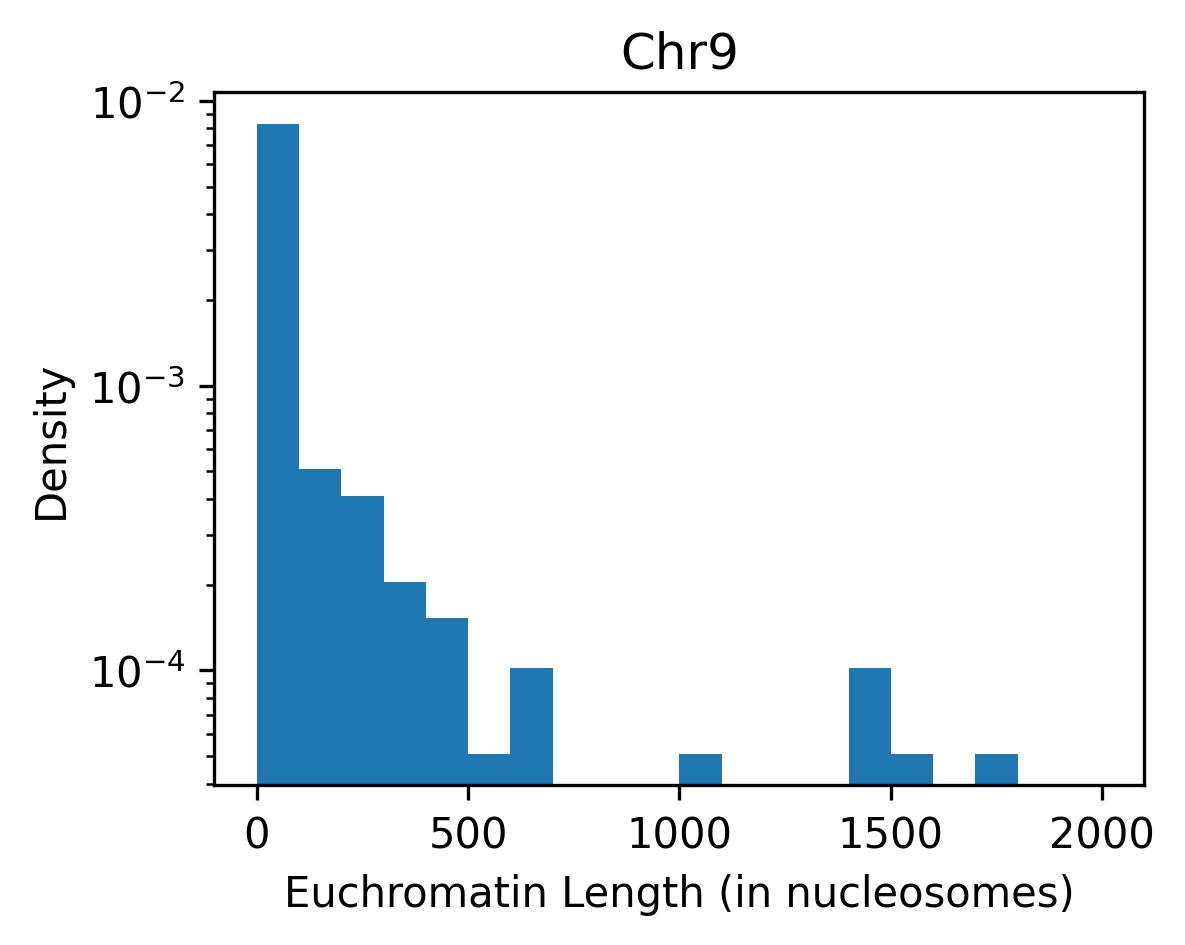

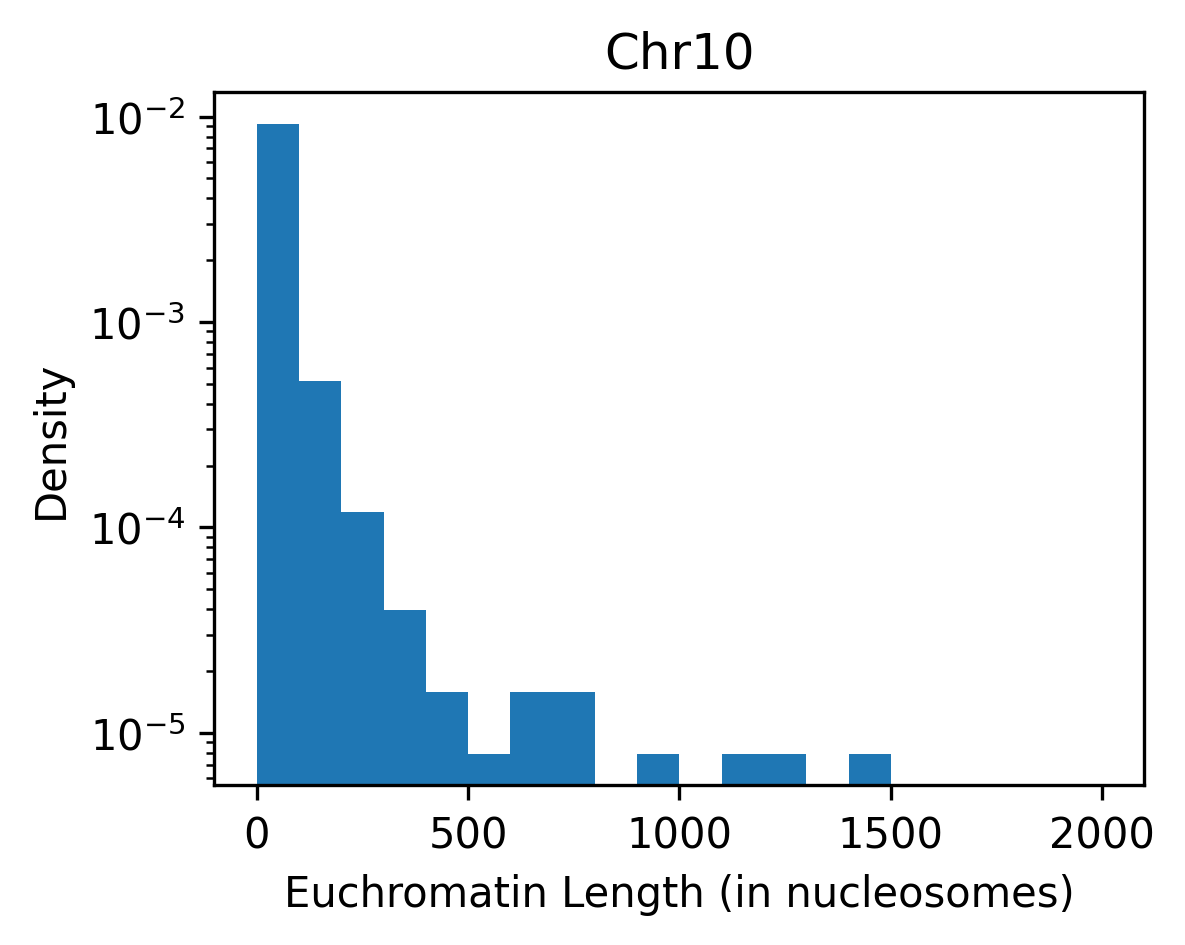

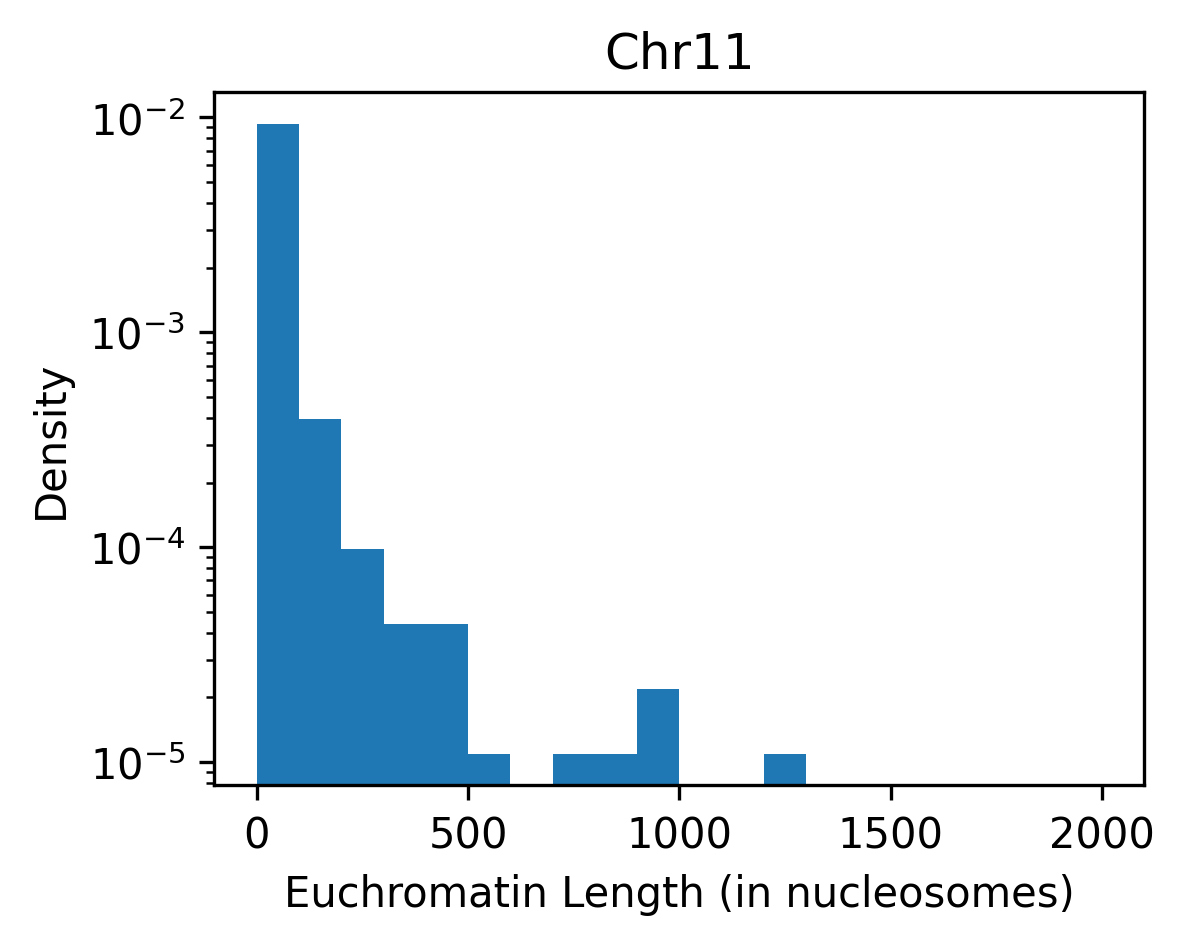

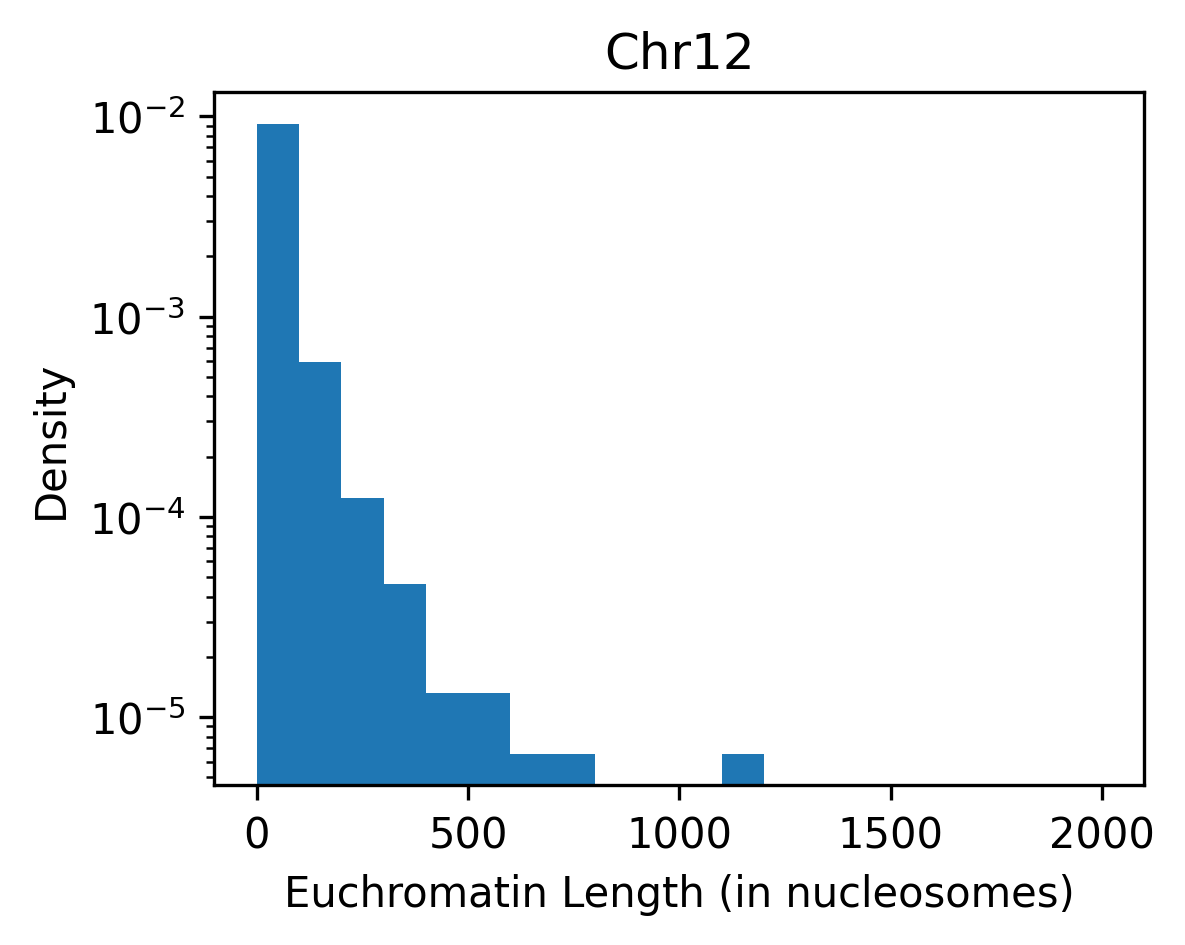

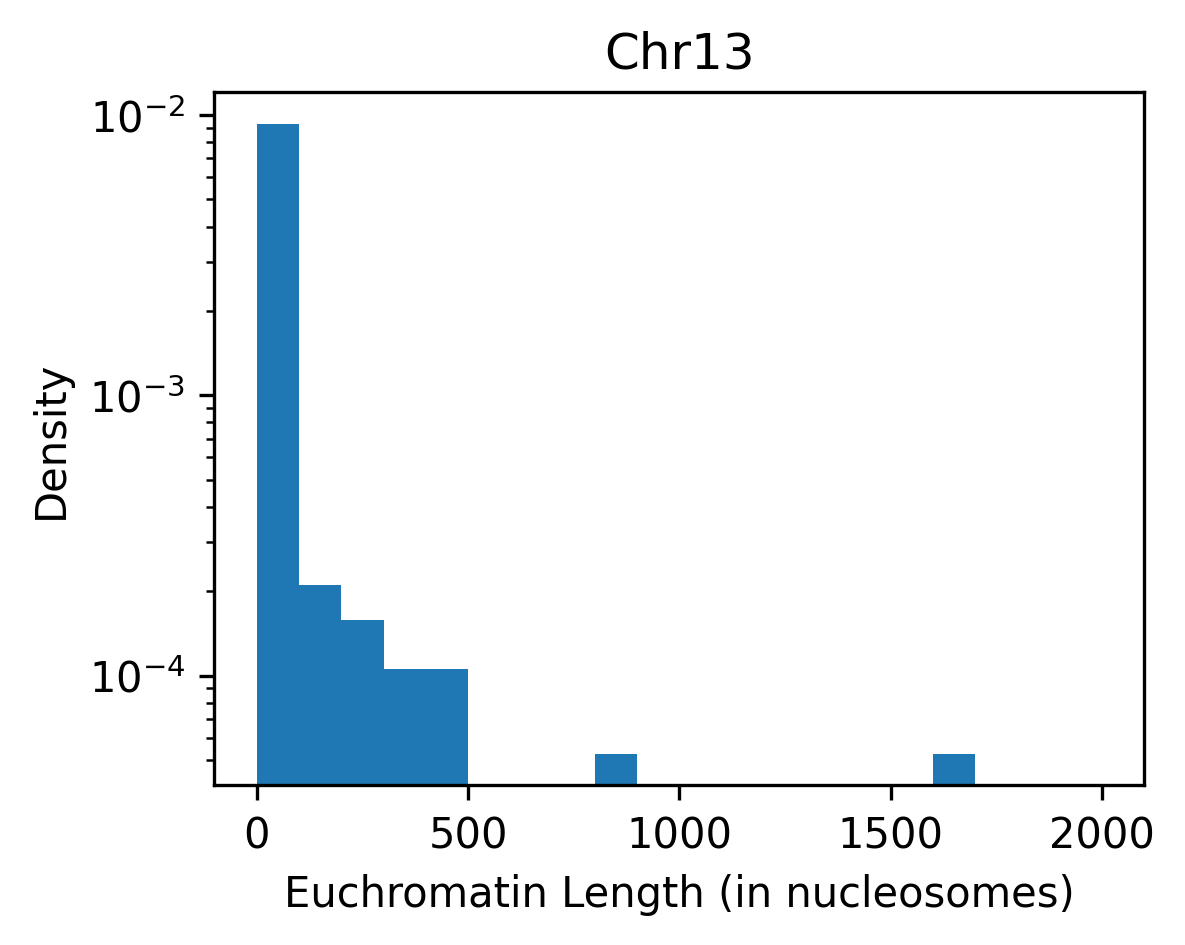

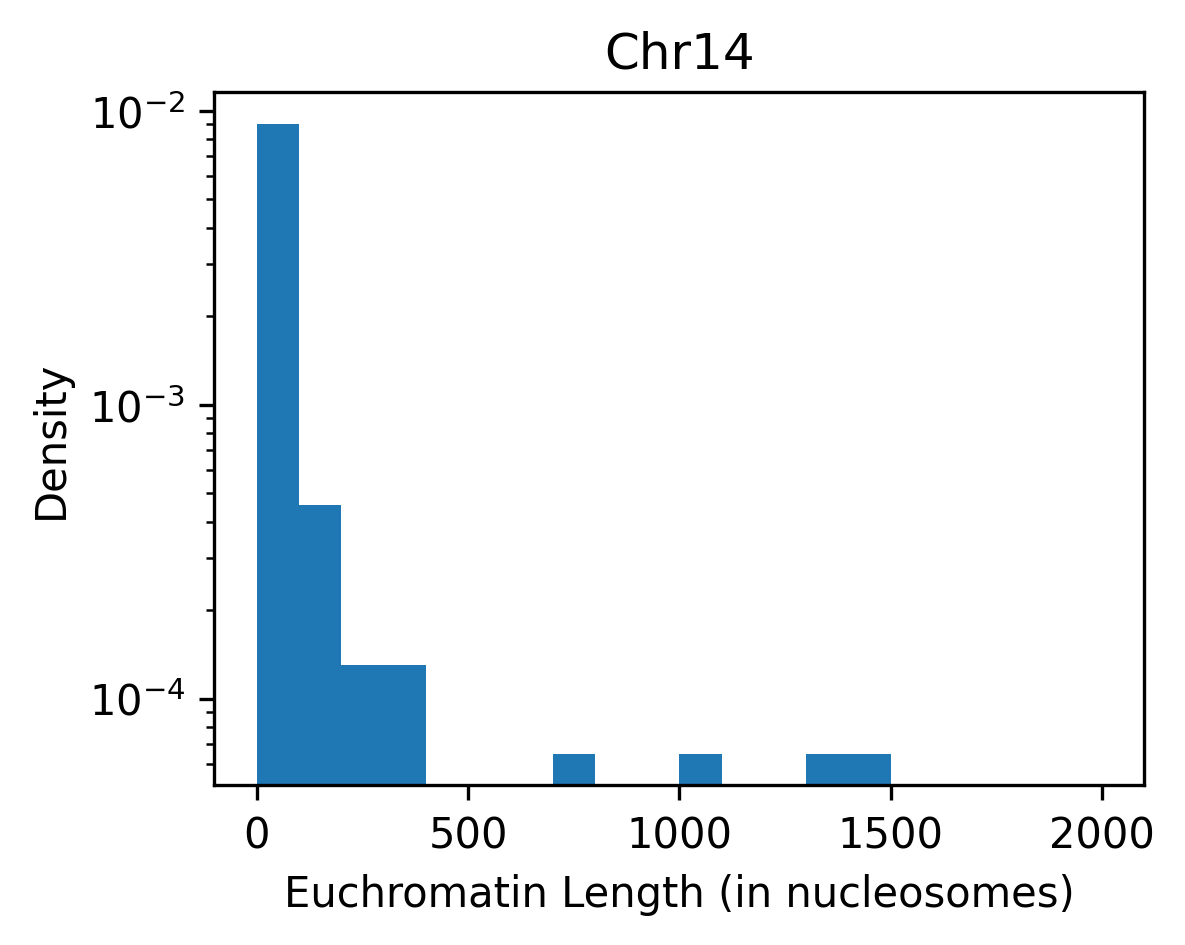

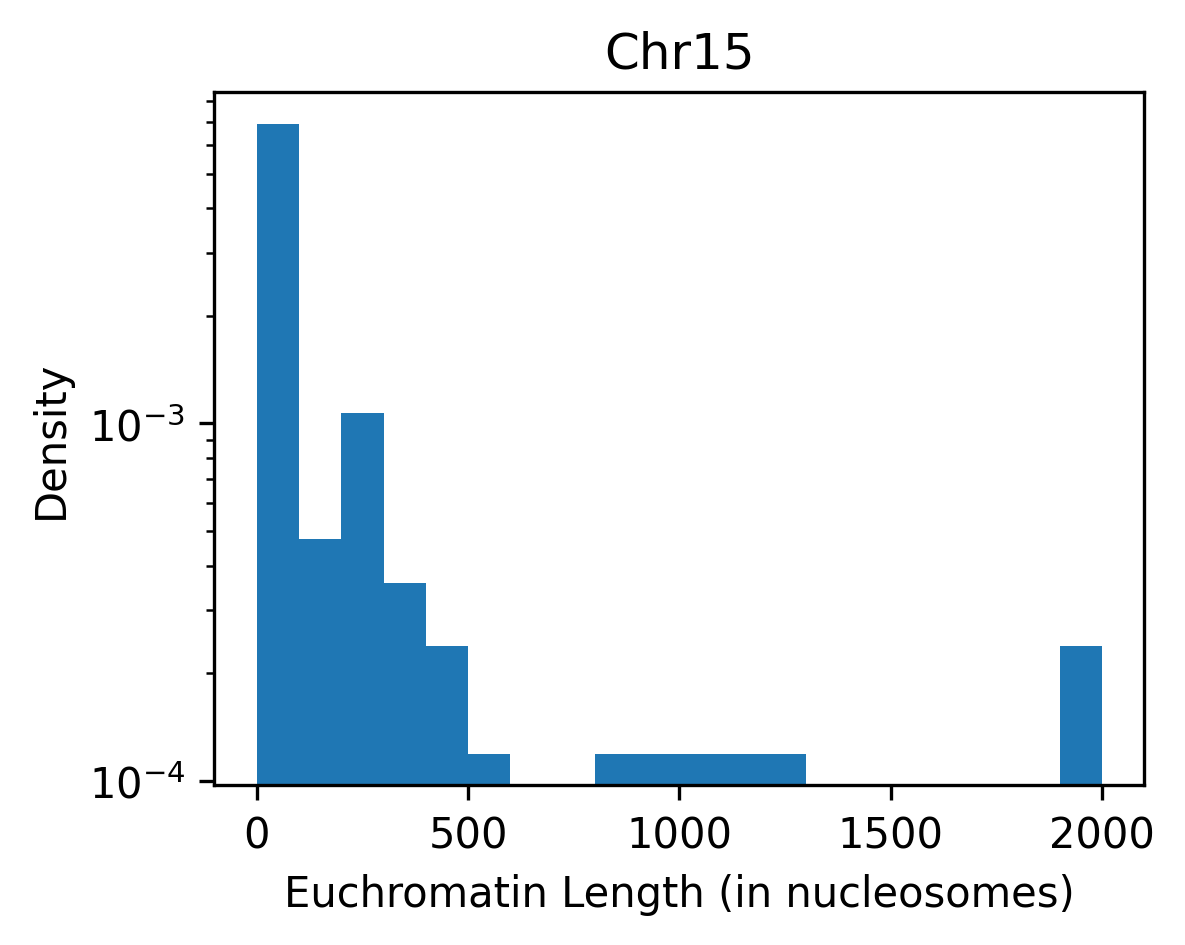

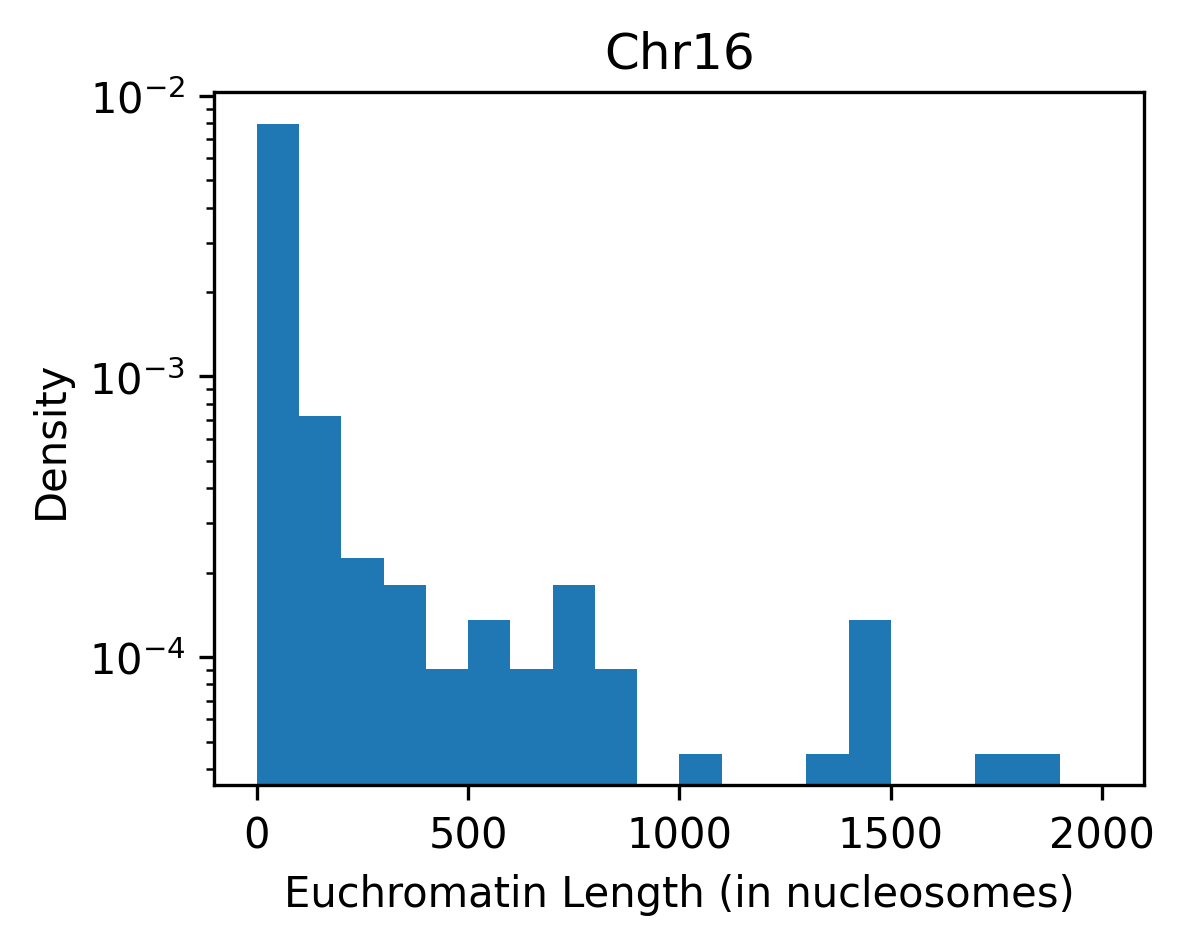

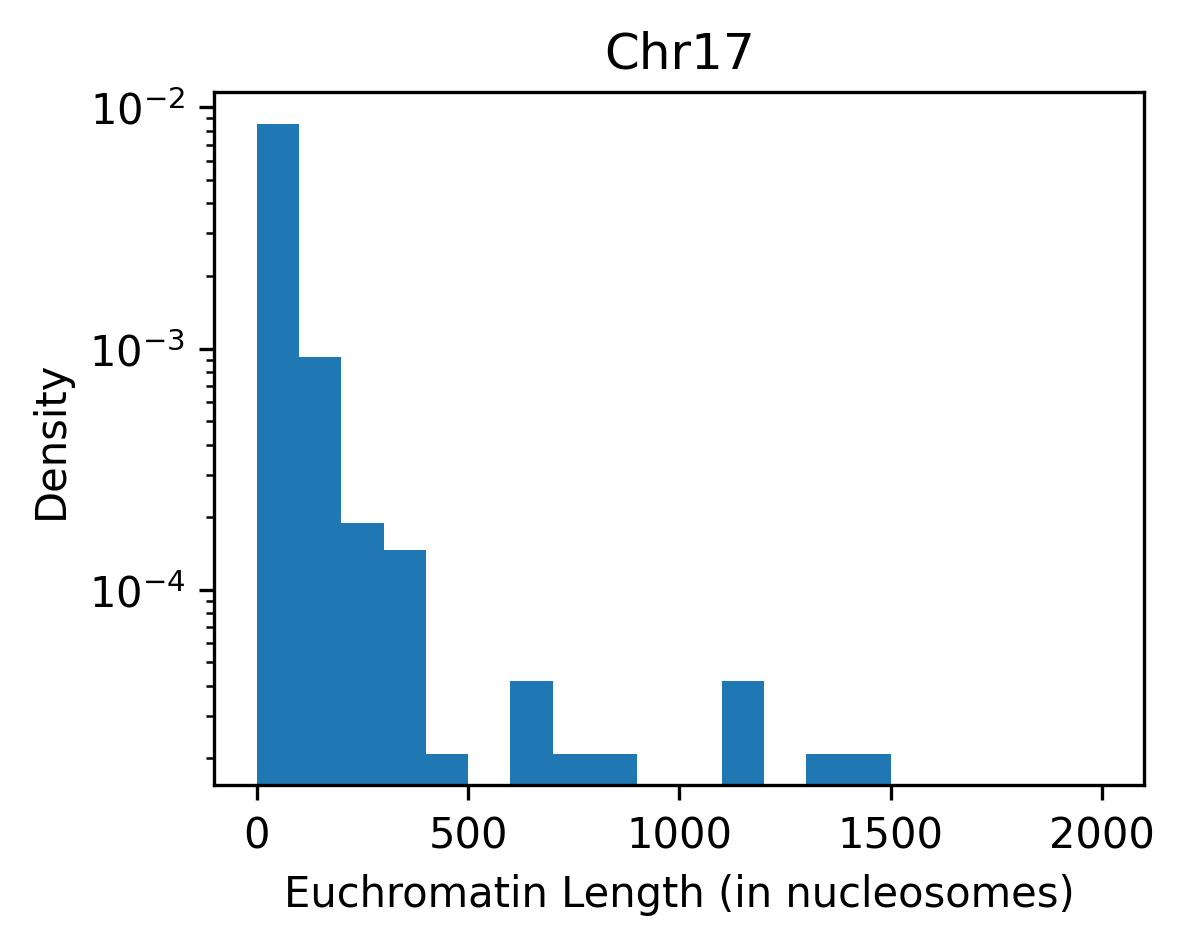

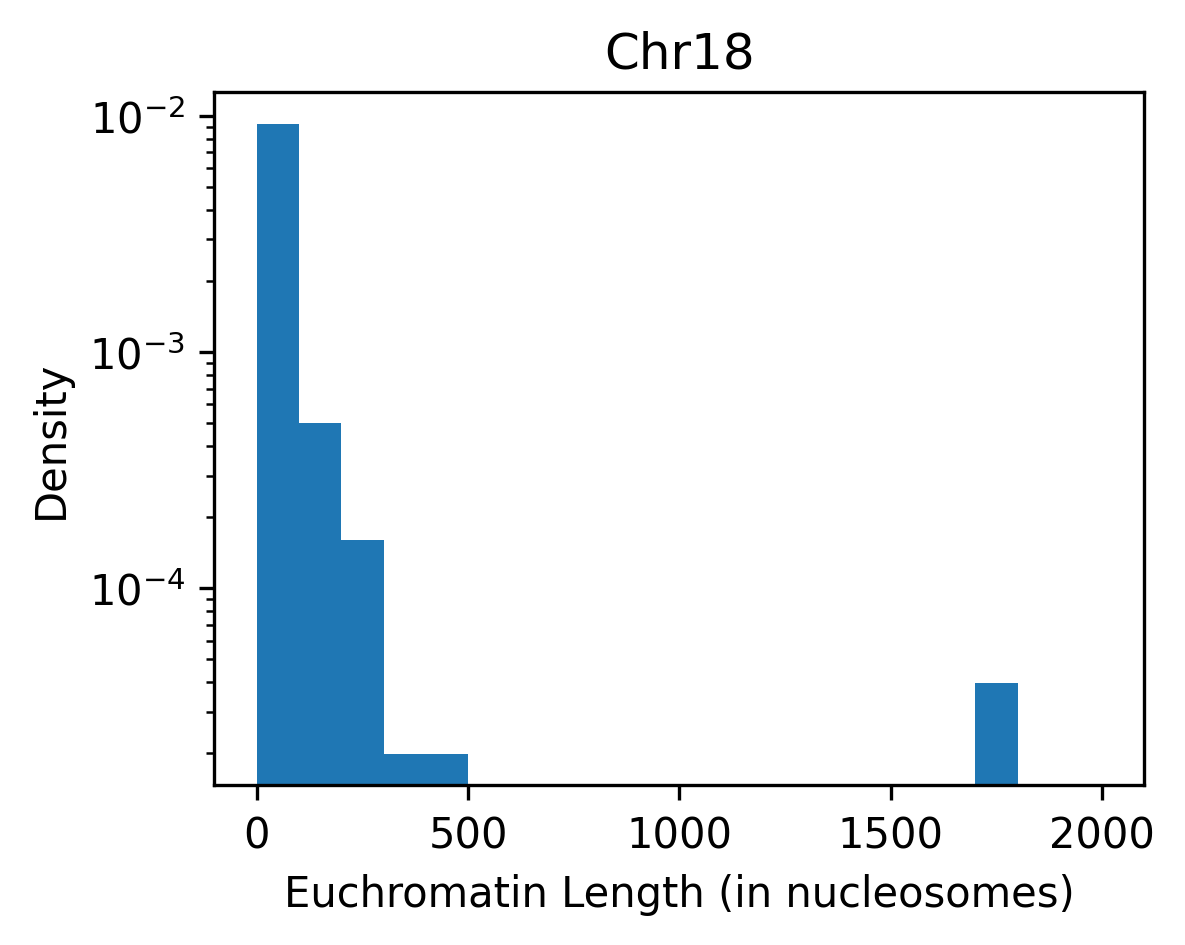

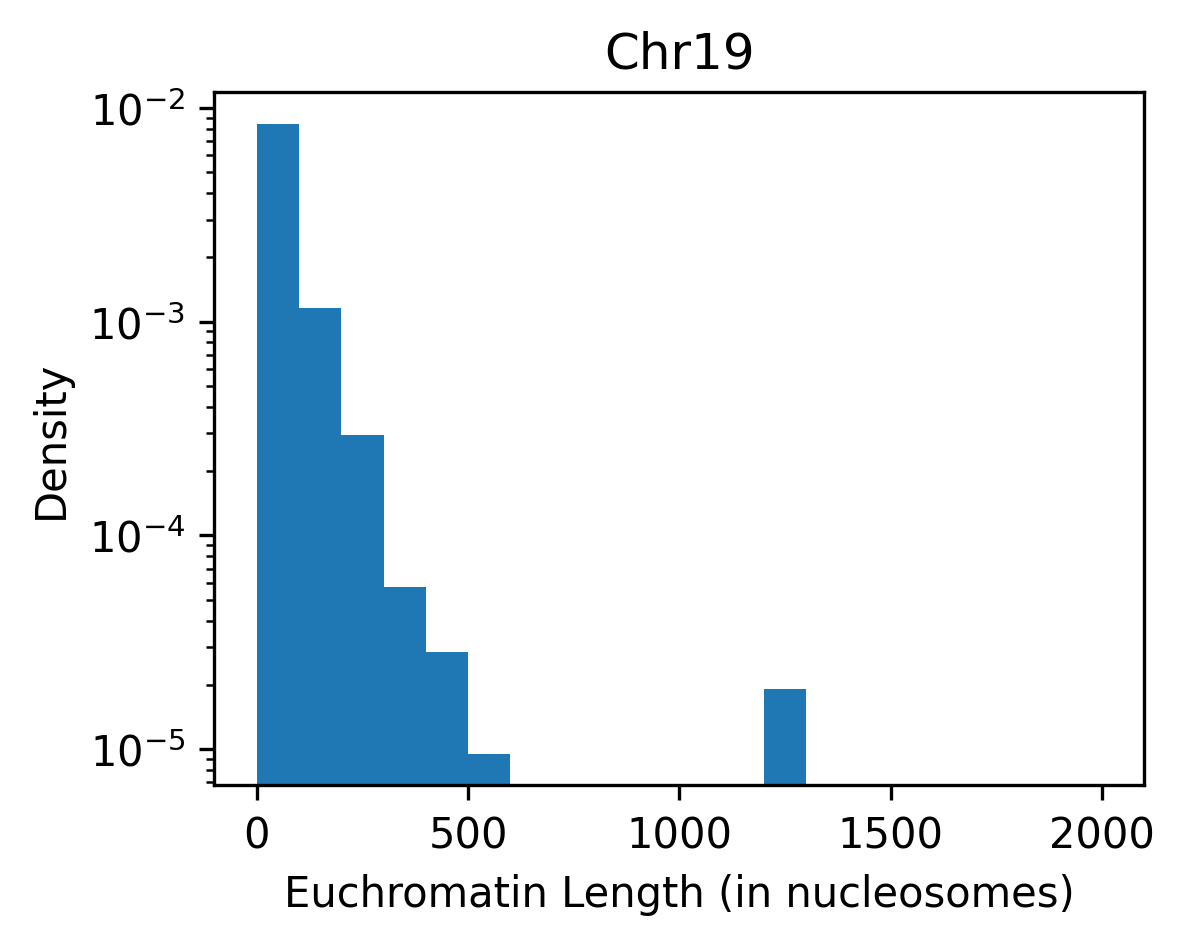

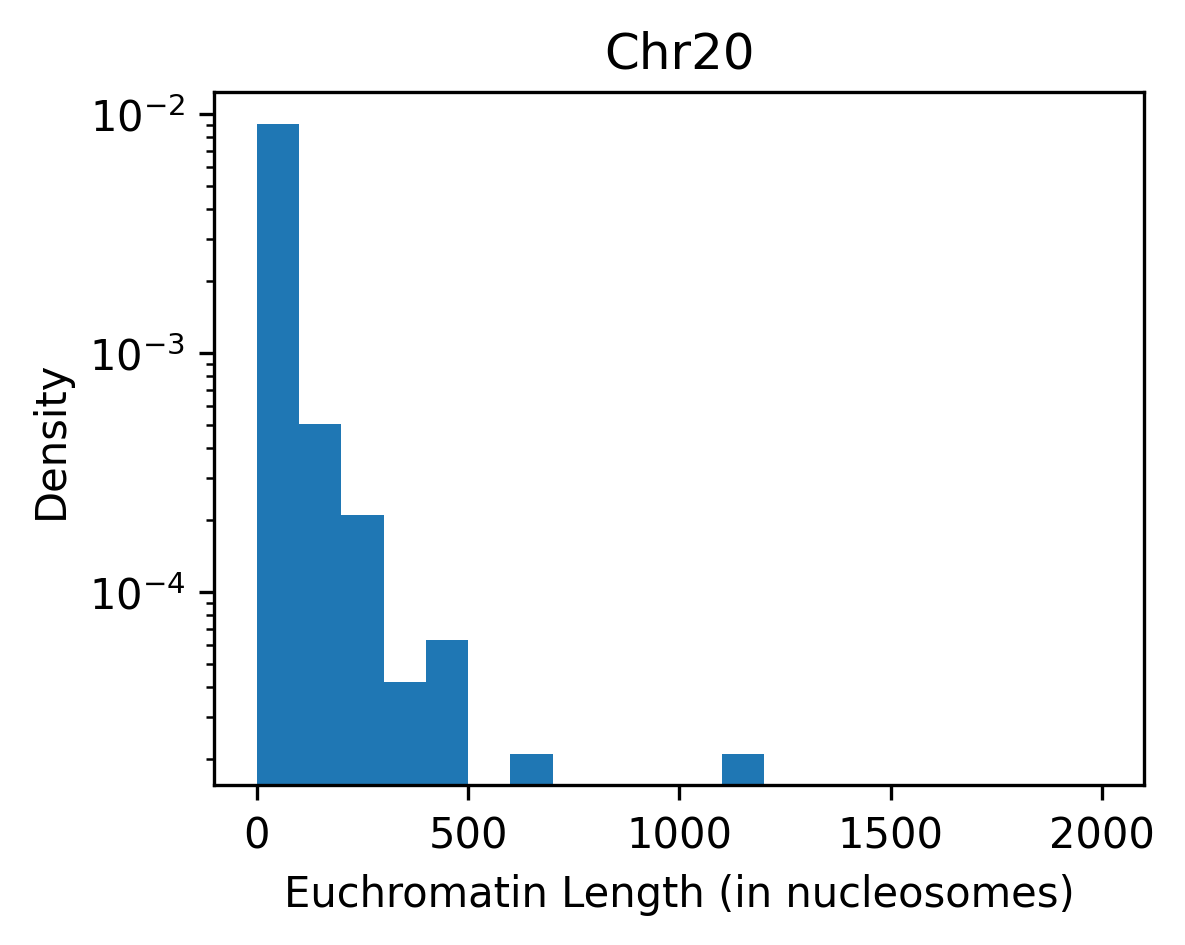

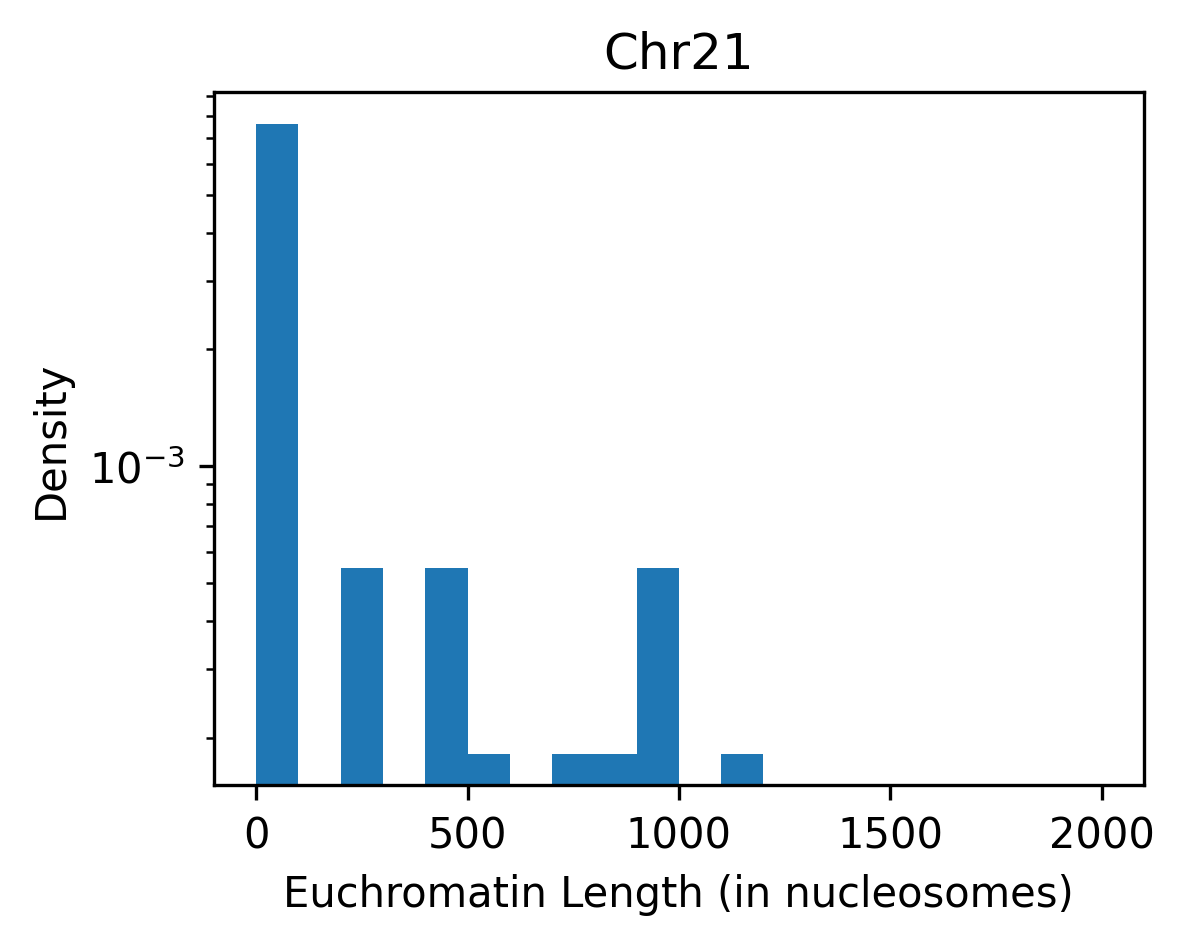

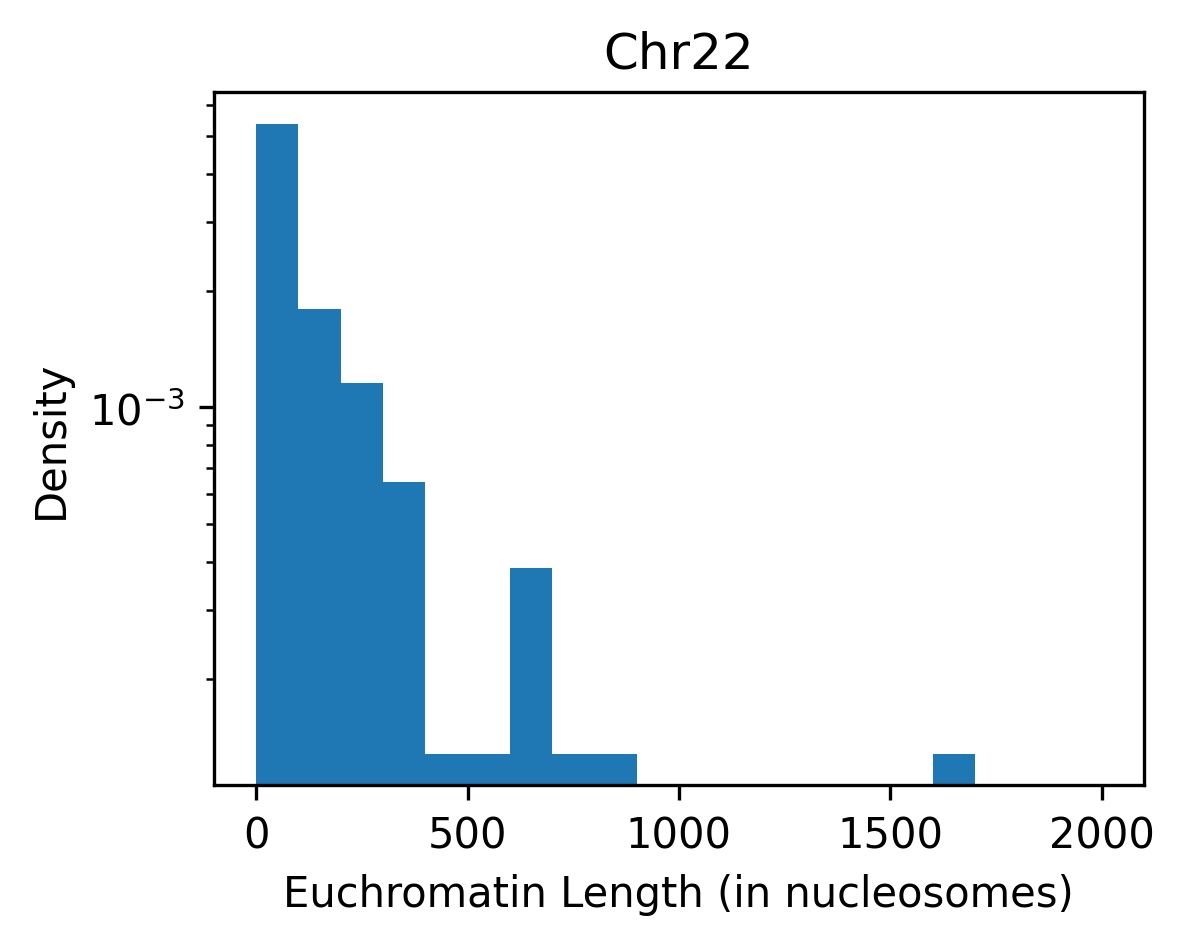

In [9]:
bins = np.linspace(0, 2000, 21)
for chr_ind, euch_lengths in euchromatin_lengths.items():
    plt.figure(figsize=(4, 3), dpi=300)
    plt.hist(euchromatin_lengths[chr_ind], bins=bins, density=True)
    plt.xlabel("Euchromatin Length (in nucleosomes)")
    plt.ylabel("Density")
    plt.title(f"Chr{chr_ind}")
    plt.yscale("log")
    plt.show()